In [1]:
# ========================================================================
#    Project: Surface Temperature Mean Daily Minimum
#    Author: Dr. Saad Laouadi
#
#
# ========================================================================
#  ®Copyright Dr. Saad Laouadi, 2025
# ========================================================================

In [2]:
# Env Setup
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf

print("*"*52)
%reload_ext watermark

%watermark -a "Dr. Saad Laouadi"
%watermark -iv -ud
print("*"*52)

****************************************************
Author: Dr. Saad Laouadi

Last updated: 2025-02-18

sklearn   : 1.5.1
tensorflow: 2.16.2
pandas    : 2.2.2
matplotlib: 3.9.2
numpy     : 1.26.4

****************************************************


In [3]:
def load_data(filepath):
    """Load the temperature data."""
    df = pd.read_csv(filepath)
    return df

def create_sequences(data, lookback):
    """Create sequences for RNN model."""
    X, y = [], []
    for i in range(len(data) - lookback):
        X.append(data[i:(i + lookback)])
        y.append(data[i + lookback])
    return np.array(X), np.array(y)

def split_data(data, train_size=0.8):
    """Split data into training and testing sets."""
    n = len(data)
    train_size = int(n * train_size)
    train_data = data[:train_size]
    test_data = data[train_size:]
    return train_data, test_data

def normalize_data(train_data, test_data):
    """Normalize data using MinMaxScaler."""
    scaler = MinMaxScaler()
    train_scaled = scaler.fit_transform(train_data.reshape(-1, 1))
    test_scaled = scaler.transform(test_data.reshape(-1, 1))
    return train_scaled, test_scaled, scaler

def build_rnn_model(lookback):
    """Build a simple RNN model."""
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape = (lookback, 1)),
        tf.keras.layers.SimpleRNN(50, activation='tanh',
                 dropout=0.2,
                 recurrent_dropout=0.2),
        tf.keras.layers.Dense(1)
    ])
    
    model.compile(optimizer='adam',
                  loss='mse',
                  metrics=[tf.keras.metrics.RootMeanSquaredError(),
                          tf.keras.metrics.MeanAbsoluteError()])
    return model

def train_model(model, X_train, y_train, epochs=500, batch_size=32):
    """Train the RNN model."""
    callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                patience=30)
    
    history = model.fit(X_train, y_train,
                       epochs=epochs,
                       batch_size=batch_size,
                       validation_split=0.2,
                       callbacks=[callback],
                       verbose=0)
    return history

def plot_training_history(history):
    """Plot training history."""
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['mean_absolute_error'], label='Training MAE')
    plt.plot(history.history['val_mean_absolute_error'], label='Validation MAE')
    plt.title('Model MAE')
    plt.xlabel('Epoch')
    plt.ylabel('MAE')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

def plot_predictions(actual, predictions, title):
    """Plot actual vs predicted values."""
    plt.figure(figsize=(12, 6))
    plt.plot(actual, label='Actual')
    plt.plot(predictions, label='Predicted')
    plt.title(title)
    plt.xlabel('Time Step')
    plt.ylabel('Temperature')
    plt.legend()
    plt.grid(True)
    plt.show()

In [4]:
# Main execution
# =============
# Load data
data_path = Path("../datasets/SurfaceAirTemperatureMonthlyMeanDailyMinimum.csv").resolve()
df = load_data(data_path)
df.head()

,month,temp_mean_daily_min
0,1982-01,23.3
1,1982-02,23.9
2,1982-03,24.3
3,1982-04,24.3
4,1982-05,25.2


In [5]:
df = df.set_index("month")

In [6]:
temperature_data = df['temp_mean_daily_min'].values 

In [7]:
# Split data
train_data, test_data = split_data(temperature_data)

In [8]:
# Normalize data after splitting
train_scaled, test_scaled, scaler = normalize_data(train_data, test_data)

In [9]:
# Create sequences
lookback = 12  # Use 12 months for prediction
X_train, y_train = create_sequences(train_scaled, lookback)
X_test, y_test = create_sequences(test_scaled, lookback)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(401, 12, 1)
(92, 12, 1)
(401, 1)
(92, 1)


In [10]:
# Reshape for RNN [samples, time steps, features]
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(401, 12, 1)
(92, 12, 1)
(401, 1)
(92, 1)


In [11]:
# Build and train model
model = build_rnn_model(lookback)
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, 50)             │         2,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,651 (10.36 KB)

 Trainable params: 2,651 (10.36 KB)

 Non-trainable params: 0 (0.00 B)

In [12]:
%time
history = train_model(model, X_train, y_train)

CPU times: user 1 μs, sys: 2 μs, total: 3 μs
Wall time: 4.05 μs


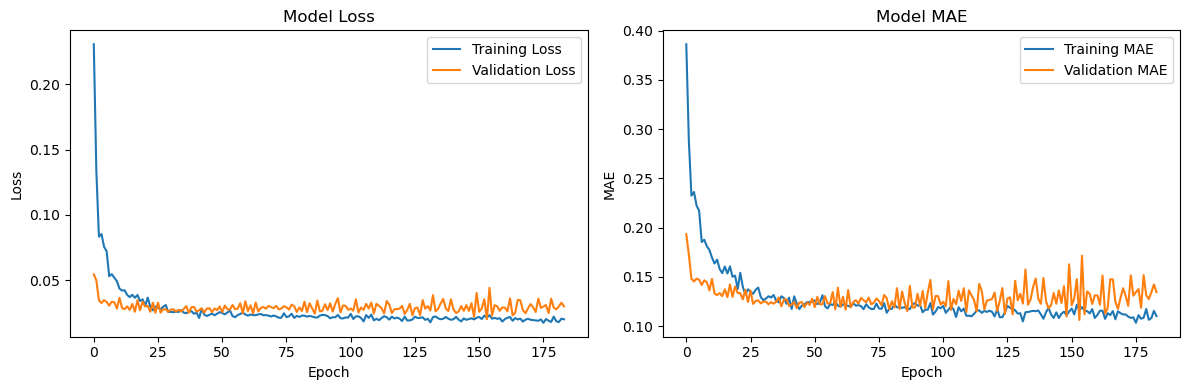

In [13]:
# Plot training history
plot_training_history(history)

In [14]:
# Make predictions
train_pred = model.predict(X_train)
test_pred = model.predict(X_test)

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


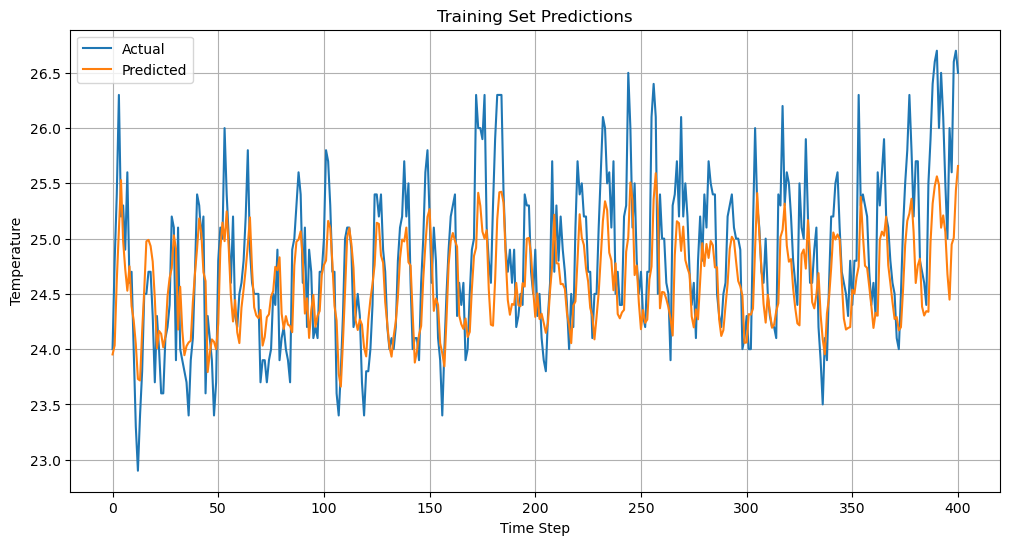

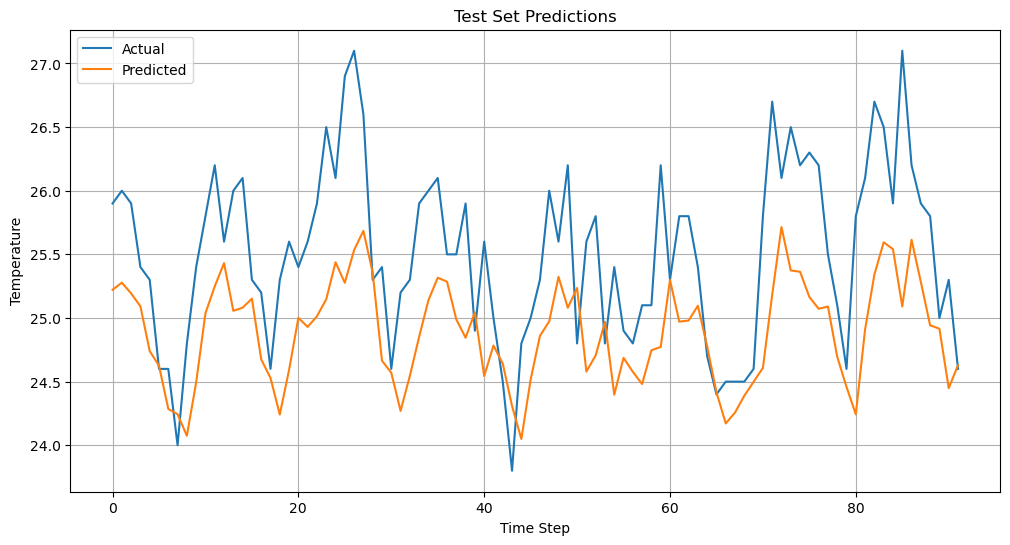

In [15]:
# Inverse transform predictions
train_pred = scaler.inverse_transform(train_pred)
test_pred = scaler.inverse_transform(test_pred)
y_train_actual = scaler.inverse_transform(y_train.reshape(-1, 1))
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

# Plot results
plot_predictions(y_train_actual, train_pred, 'Training Set Predictions')
plot_predictions(y_test_actual, test_pred, 'Test Set Predictions')

In [16]:
# Calculate and print metrics
train_mae = np.mean(np.abs(y_train_actual - train_pred))
test_mae = np.mean(np.abs(y_test_actual - test_pred))
print(f'\nTraining MAE: {train_mae:.2f}')
print(f'Test MAE: {test_mae:.2f}')


Training MAE: 0.41
Test MAE: 0.66
